Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год.

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель

    Обучите модели на 80% временного ряда

    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей

    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

Date
2016-04-03     744.738013
2016-04-10     741.642004
2016-04-17     748.621997
2016-04-24     750.223999
2016-05-01     704.232019
                 ...     
2021-02-28    2059.825977
2021-03-07    2068.338037
2021-03-14    2061.717993
2021-03-21    2065.902002
2021-03-28    2043.304004
Freq: W-SUN, Name: Close, Length: 261, dtype: float64


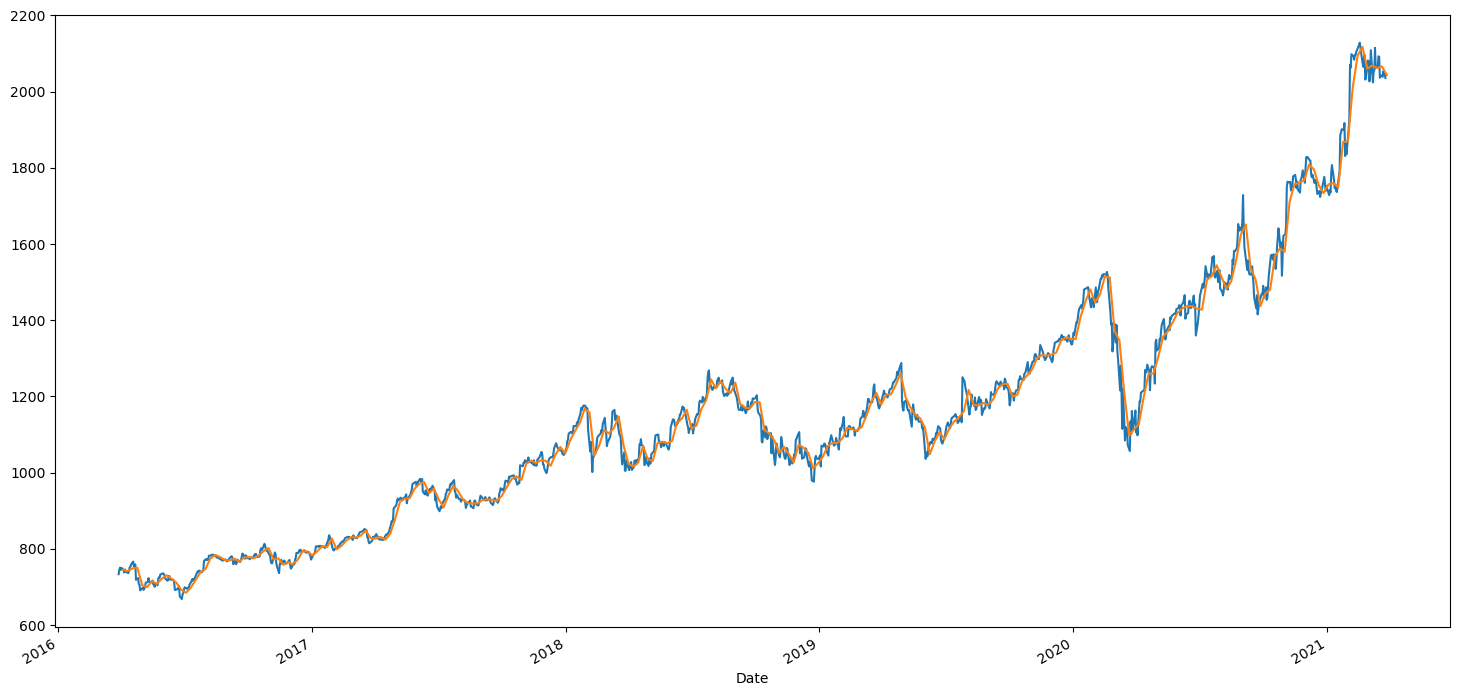

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima.arima import auto_arima
from scipy.optimize import minimize
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

plt.rcParams["figure.figsize"] = (18, 9)

df = pd.read_csv('archive/Google_Historical_StockPrice2.csv')

df.Date = pd.to_datetime(df.Date)
df.index = df.Date
df.Close.plot()

df = df.resample('W').mean()

close = df.Close
close.plot()

print(close)
plt.show()

In [2]:
def decompose(data):
    decompose = seasonal_decompose(data)
    # plt.title()
    decompose.plot()
    plt.show()

def check_stationary(data):
    import statsmodels.api as sm
    test = sm.tsa.adfuller(data)

    print('adf: ', test[0])
    print('p-value: ', round(test[1], 4))
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')

def undiff(first: pd.Series, data: pd.Series) -> pd.Series:
    new = pd.Series(first + data)
    new[0] = first[0]
    for i in range(1, len(new)):
        new[i] = new[i-1] + data[i-1]
    return new

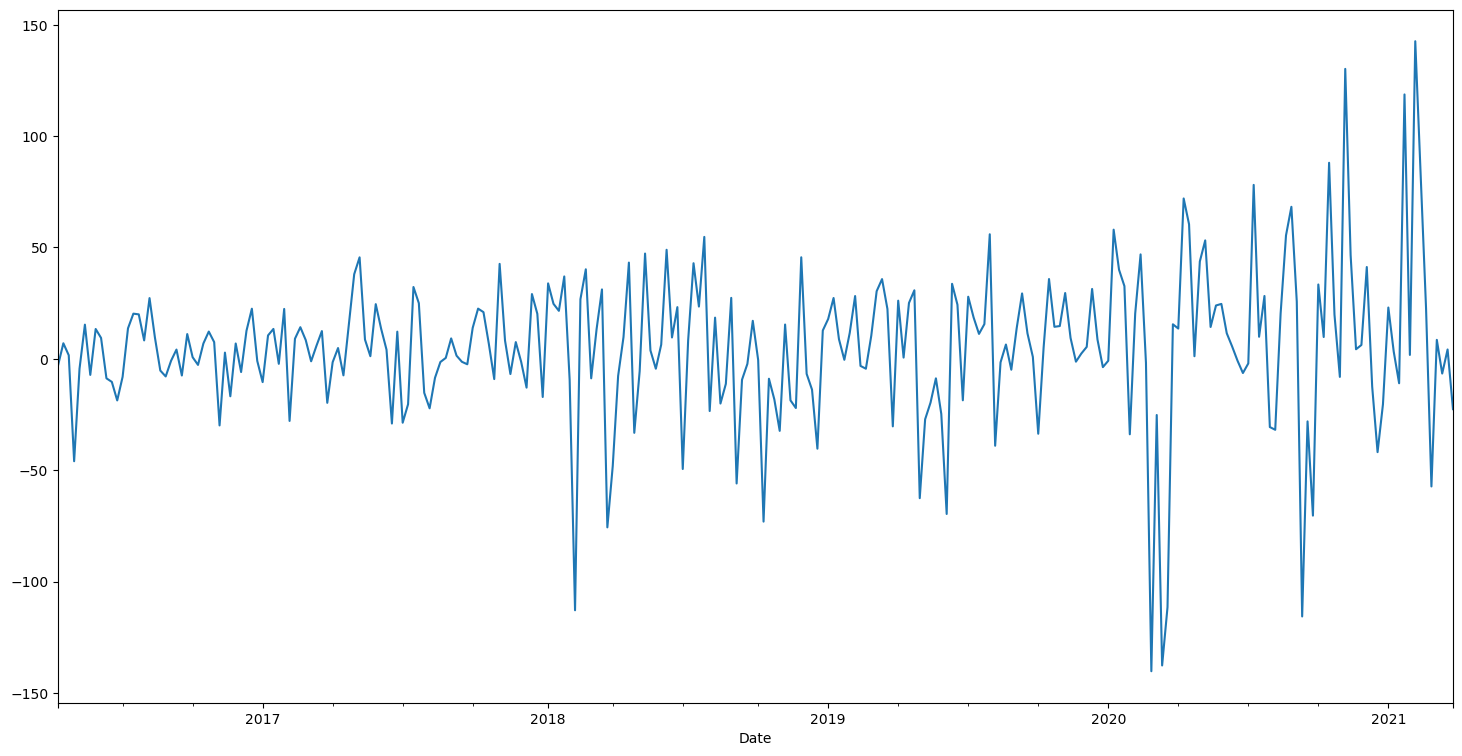

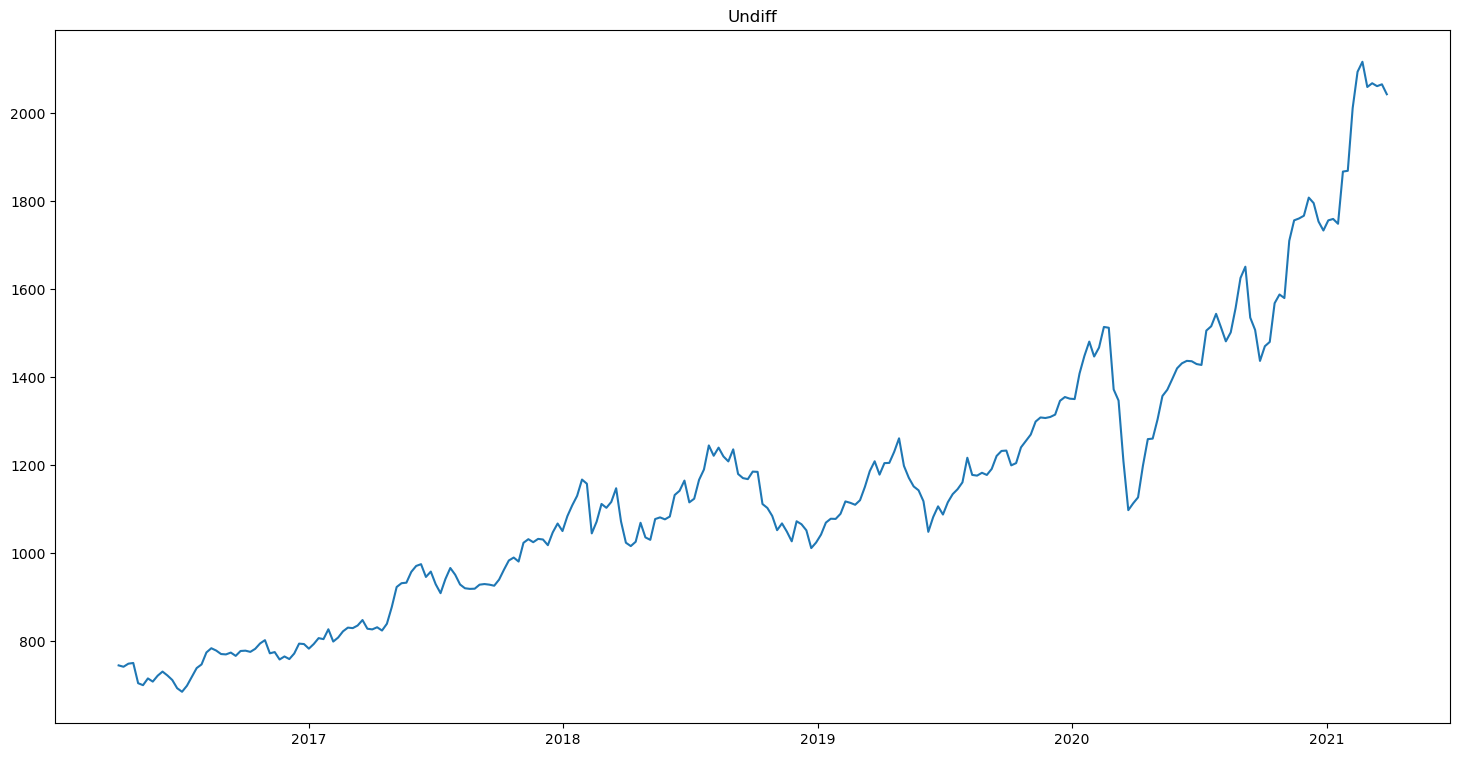

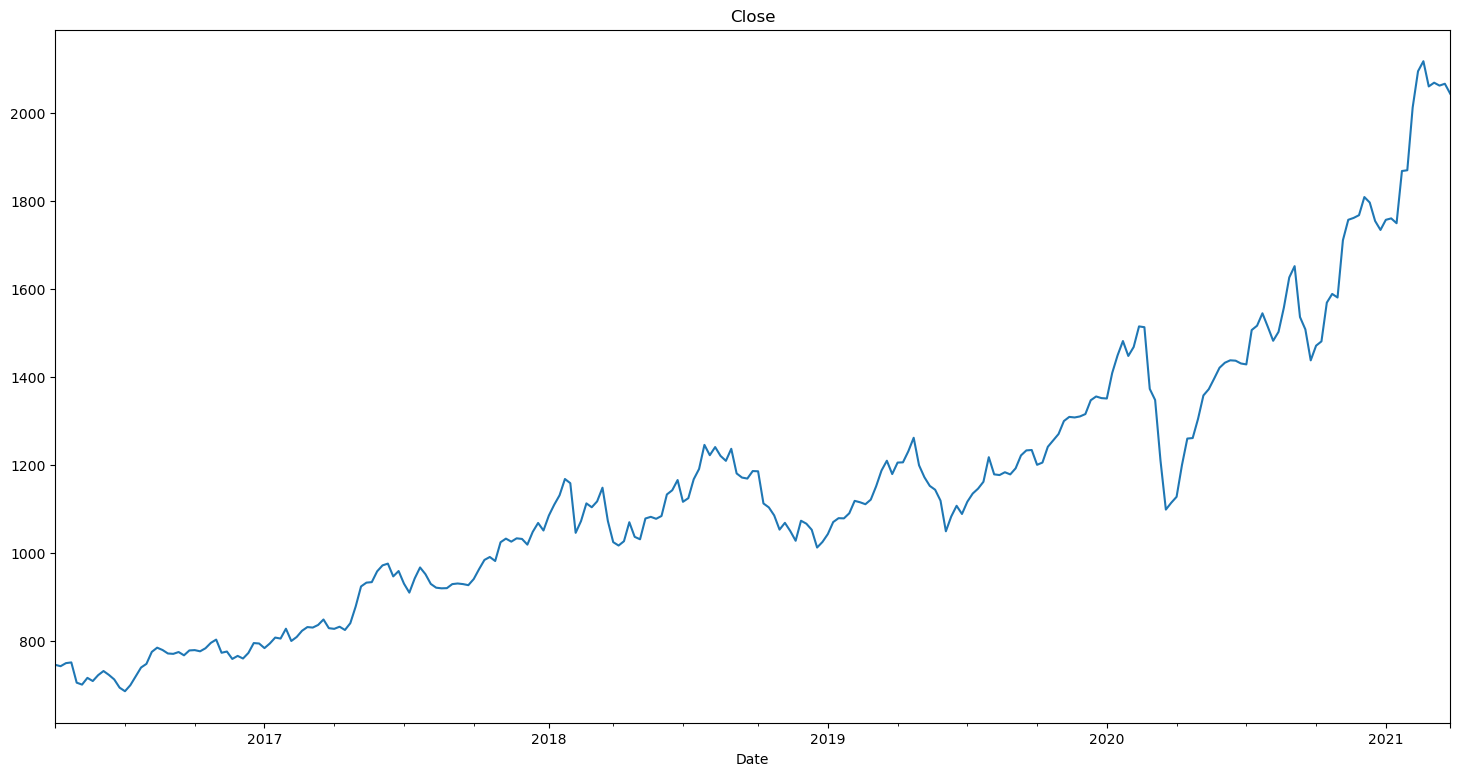

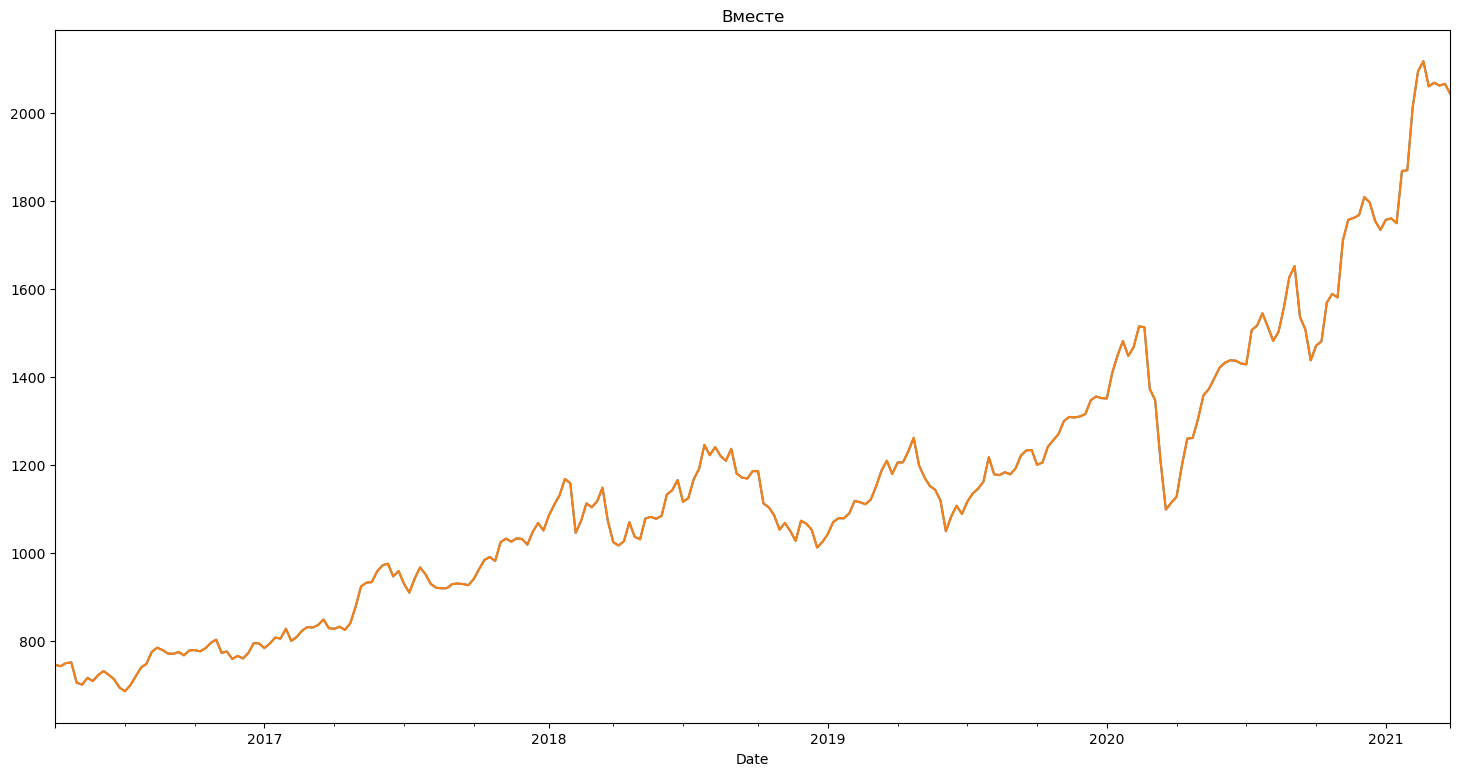

In [3]:
diff = close.diff()[1:]
diff.plot()
plt.show()
_undiff = undiff(close[0:1], diff)
plt.plot(_undiff)
plt.title("Undiff")
plt.show()

close.plot()
plt.title("Close")
plt.show()

_undiff.plot()
close.plot()
plt.title("Вместе")
plt.show()

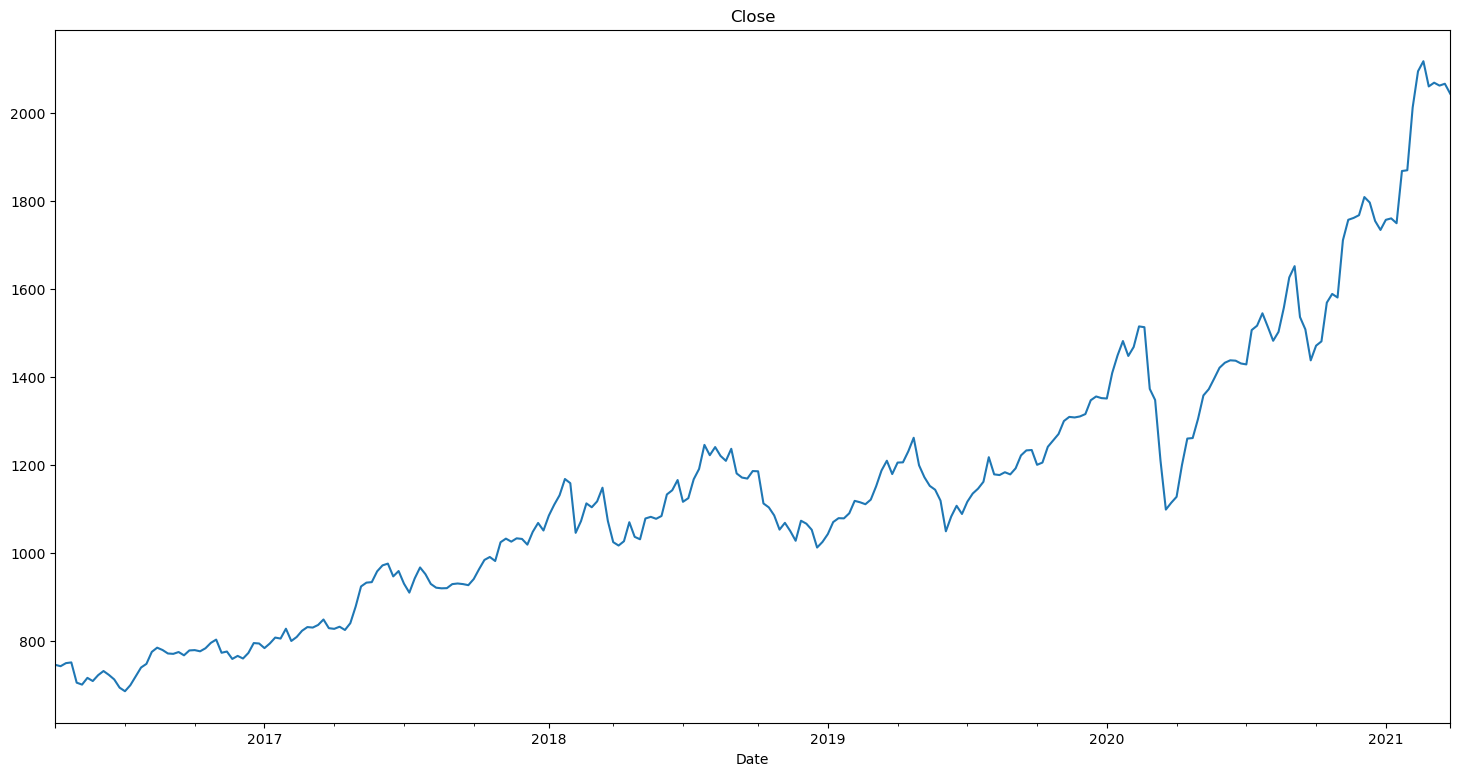

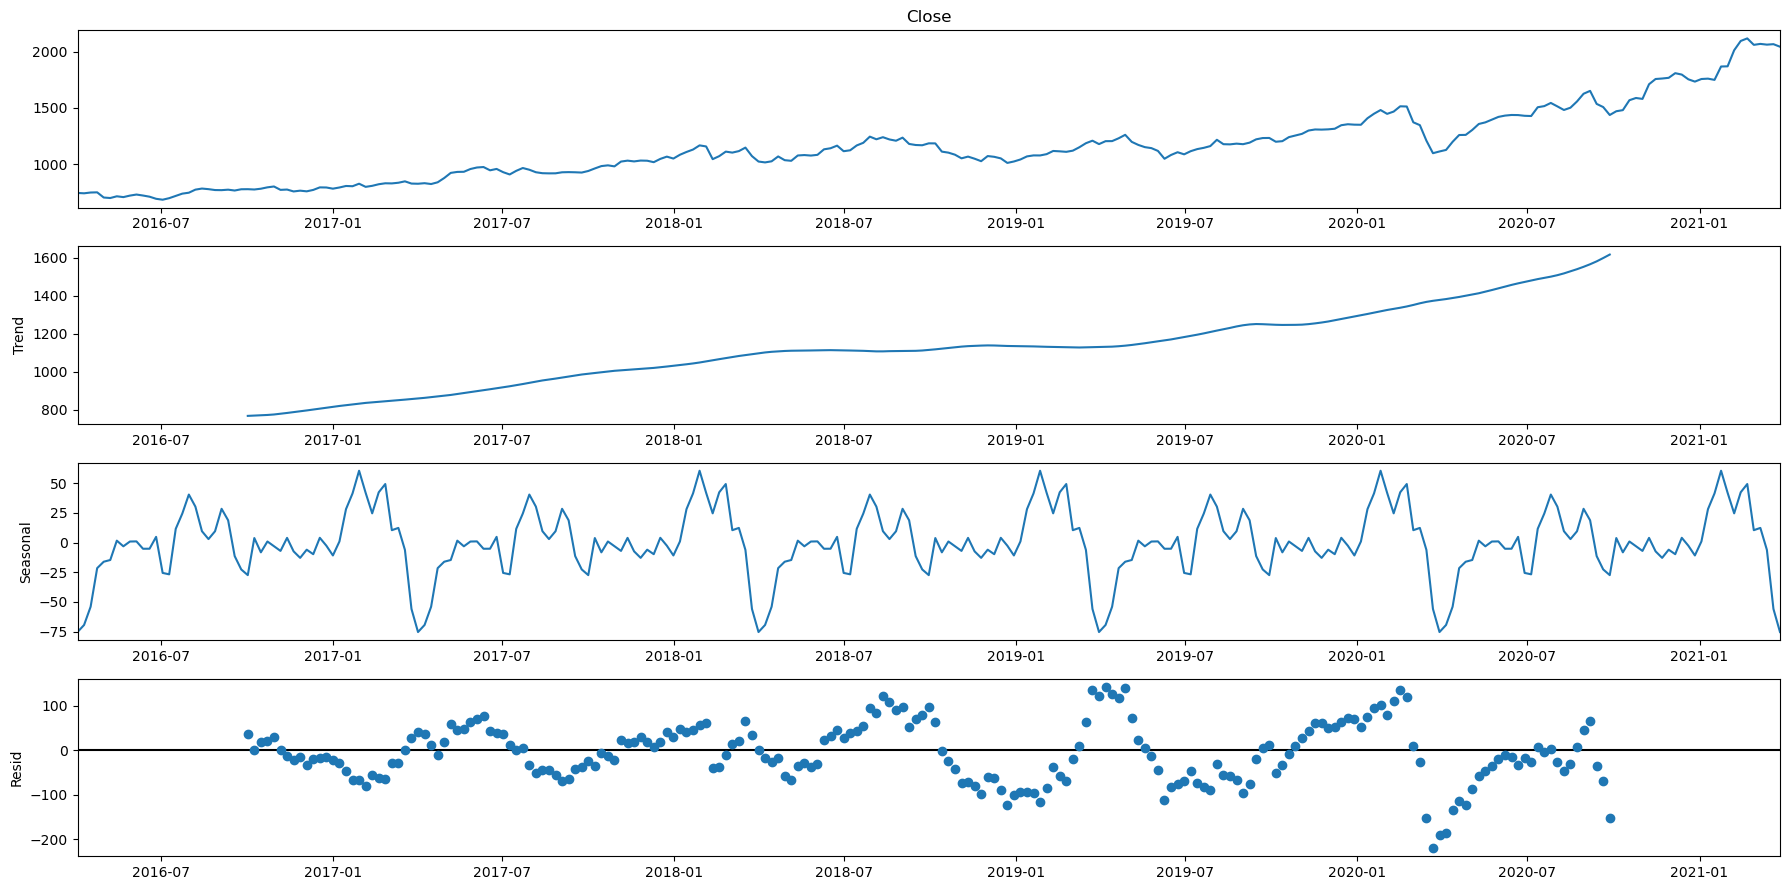

adf:  0.3753972411750078
p-value:  0.9806
Critical values:  {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
Ряд не стационарен


In [4]:
close.plot()
plt.title("Close")
plt.show()
decompose(close)
check_stationary(close)

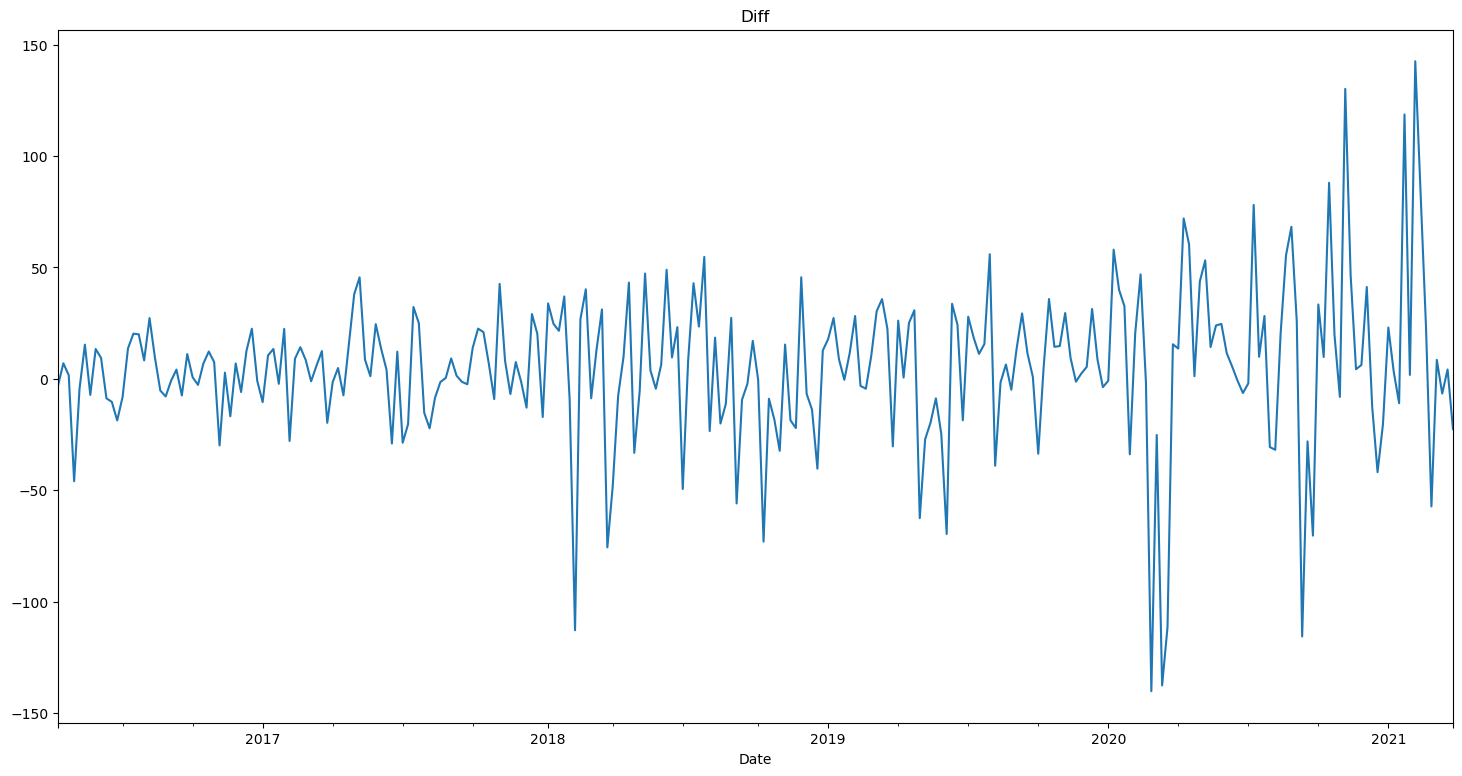

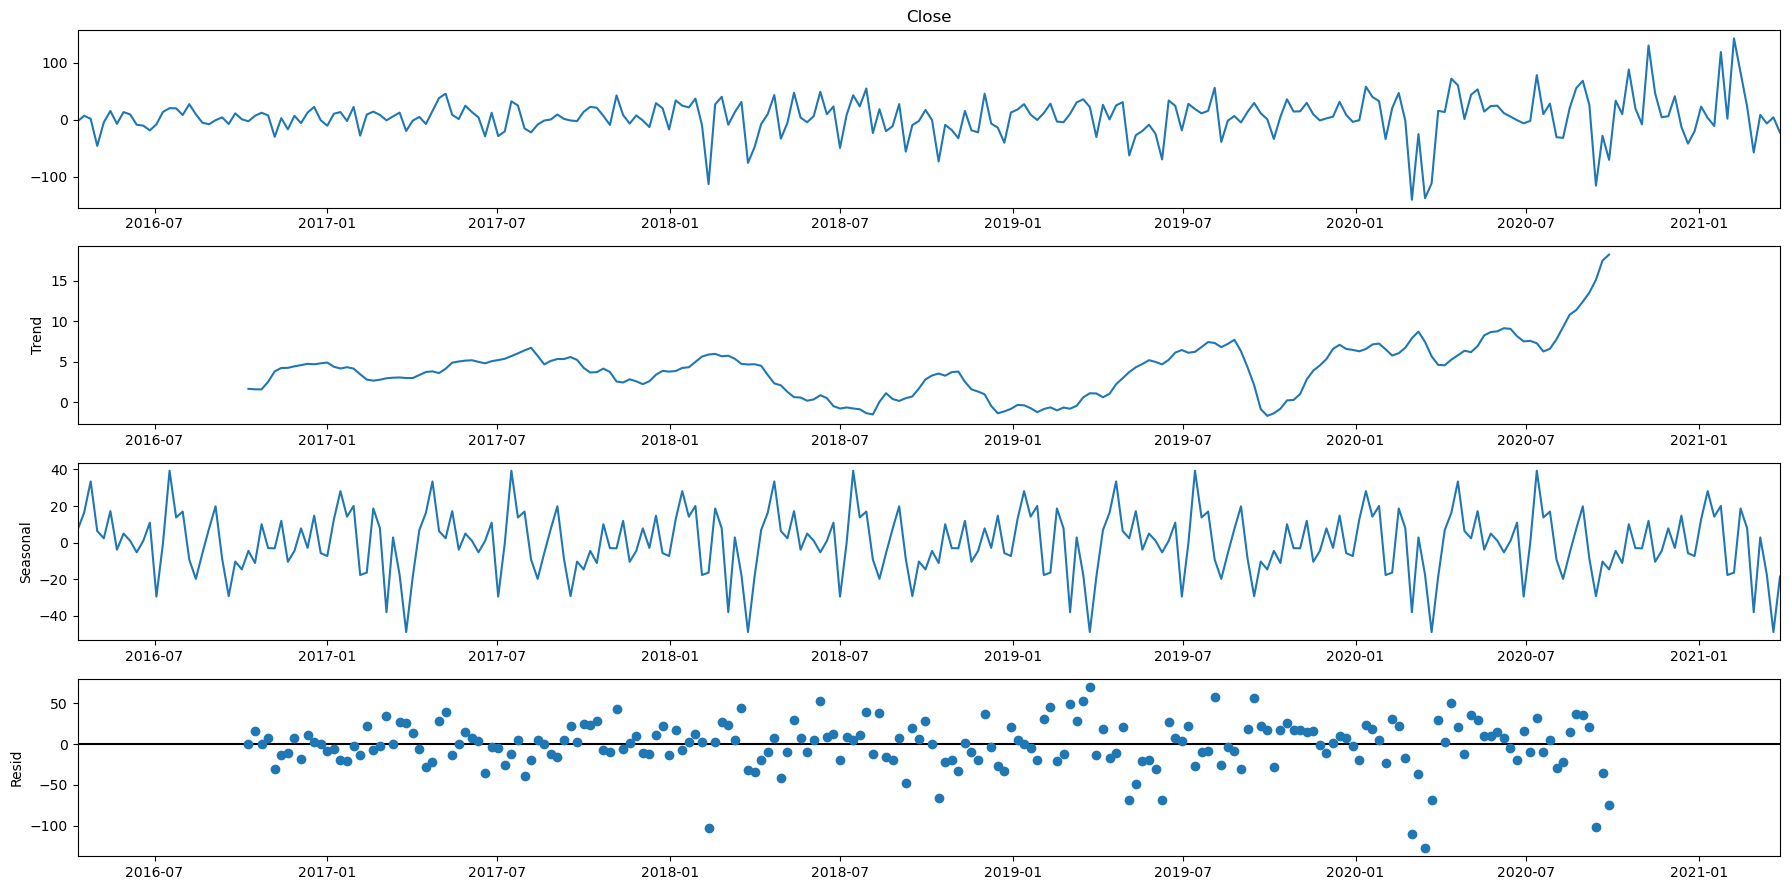

adf:  -13.04098239928806
p-value:  0.0
Critical values:  {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
Ряд стационарен


In [5]:
diff.plot()
plt.title("Diff")
plt.show()
decompose(diff)
check_stationary(diff)

In [1]:
# boxcox_lambda = 0.2
# boxdata = boxcox(close, boxcox_lambda)
#
# boxdata.plot()
# plt.title("Boxcox")
# plt.show()
# decompose(boxdata)
# check_stationary(boxdata)

In [7]:
# k = 0.0000032
#
# def rotate(data):
#     result = []
#     for index, value in enumerate(data):
#         result.append(value - index * k)
#     return result
#
#
# def inv_rotate(data, align=0):
#     result = []
#     for index, value in enumerate(data):
#         result.append(value + (align + index) * k)
#     return result

# boxcox_lambda = -1

# df['CloseBoxcox'] = boxcox(df.Close, boxcox_lambda)
# df['CloseRotatedBoxcox'] = rotate(boxcox(df.Close, boxcox_lambda))
#
# line = pd.DataFrame({'CloseBoxcox': [df.CloseBoxcox[0] + i * k for i in range(len(df))], 'Date': df.index})
# line = line.set_index('Date')
#
# df.CloseBoxcox.plot()
# line.CloseBoxcox.plot()
# df.CloseRotatedBoxcox.plot()
#
# plt.show()

In [40]:
def HolterWinter(data, L, alpha, beta, gamma, m):
    # находим изначальные сезонности
    season_num = int(len(data) / L)  # кол-во сезонов
    seasonalities = {}  # сами сезонности
    season_avgs = []  # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L * i: L * i + L]) / float(L) for i in range(season_num)]
    # находим начальные значения сезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L * j + i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сглаженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    # smooth = []
    # season = []
    # trend = []

    smooth_val = data[0]  # первое значения сглаживания
    trend_val = sum([(float(data[i + L] - data[i]) / L) for i in range(L)]) / L  # первое значения тренда
    result.append(data[0])  # первая точка данных совпадает с исходной
    # smooth.append(smooth_val)  # добавляем первое значение сглаживание в массив трендов
    # trend.append(trend_val)  # добавляем первое значение тренда в массив трендов
    # season.append(seasonalities[0])  # см mod L
    # пройдемся по всем данным + длина предсказания m
    for i in range(1, len(data) + m):
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m * trend_val) + seasonalities[i % L])
        else:  # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha * (data[i] - seasonalities[i % L]) + (1 - alpha) * (
                    smooth_val + trend_val)  # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val * (1 - beta)  # обновляем bx
            seasonalities[i % L] = gamma * (data[i] - smooth_val) + (1 - gamma) * seasonalities[i % L]  # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i % L])  # записываем результат

            # smooth.append(smooth_val)
            # trend.append(trend_val)
            # season.append(seasonalities[i % L])
    return result[-m:]

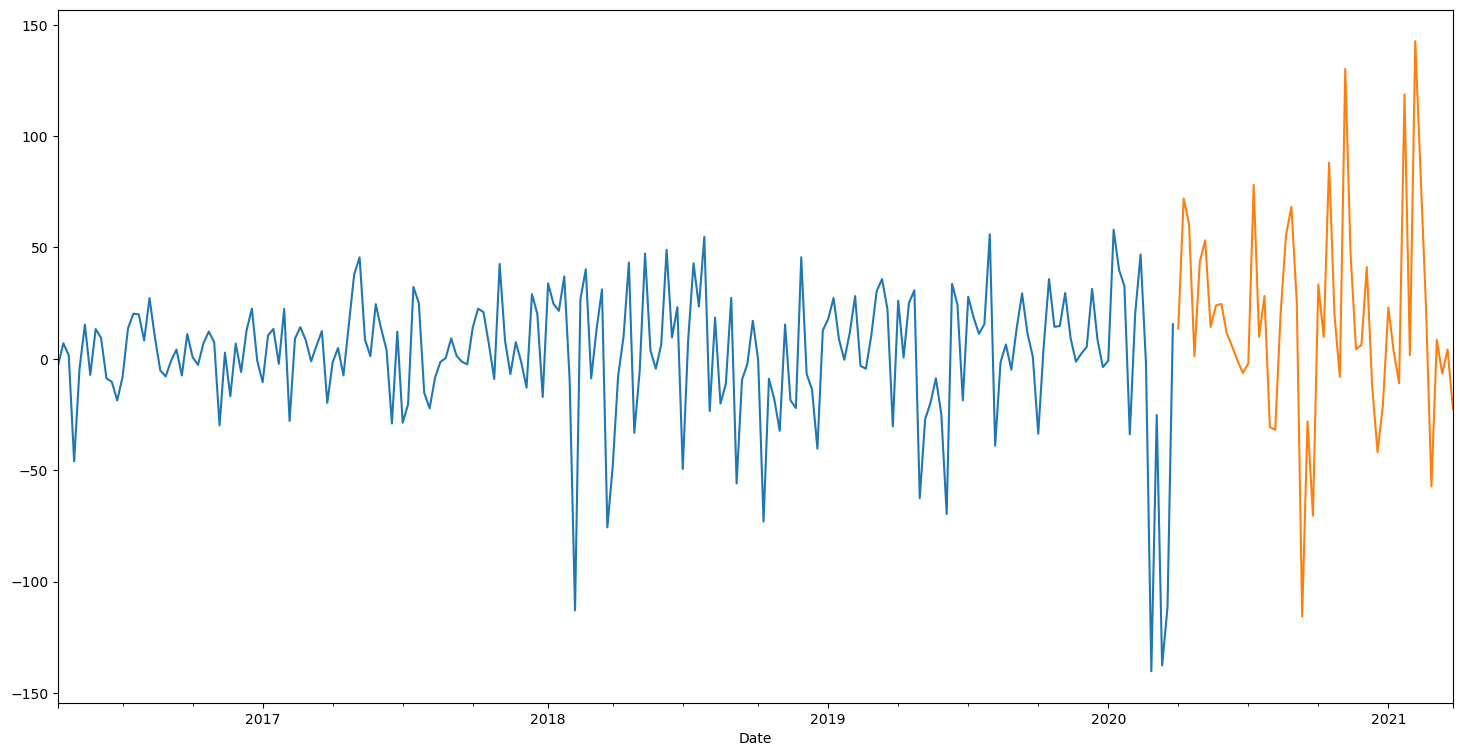

In [41]:
from sklearn.model_selection import TimeSeriesSplit

_data = diff

_train = _data[:int(len(_data) * 0.8)]
_test = _data[len(_train):]
_train.plot()
_test.plot()
plt.show()

L = 22
n_splits = 4

def timeseriesCVscore(w):
    # вектор ошибок
    errors = []
    values = _train
    alpha, beta, gamma = w

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # идем по фолдам кросс-валидации, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        # тут preds - все сглаженное + предсказания (т.е. надо обрезать под размер теста - [-len(test):])
        preds = HolterWinter(data=values[train], L = L, alpha=alpha, beta=beta, gamma=gamma, m=len(test))
        error = mean_squared_error(preds[-len(test):], values[test])
        # print(error, alpha, beta, gamma)
        errors.append(error)
    # возвращаем усреднение
    return np.mean(np.array(errors))

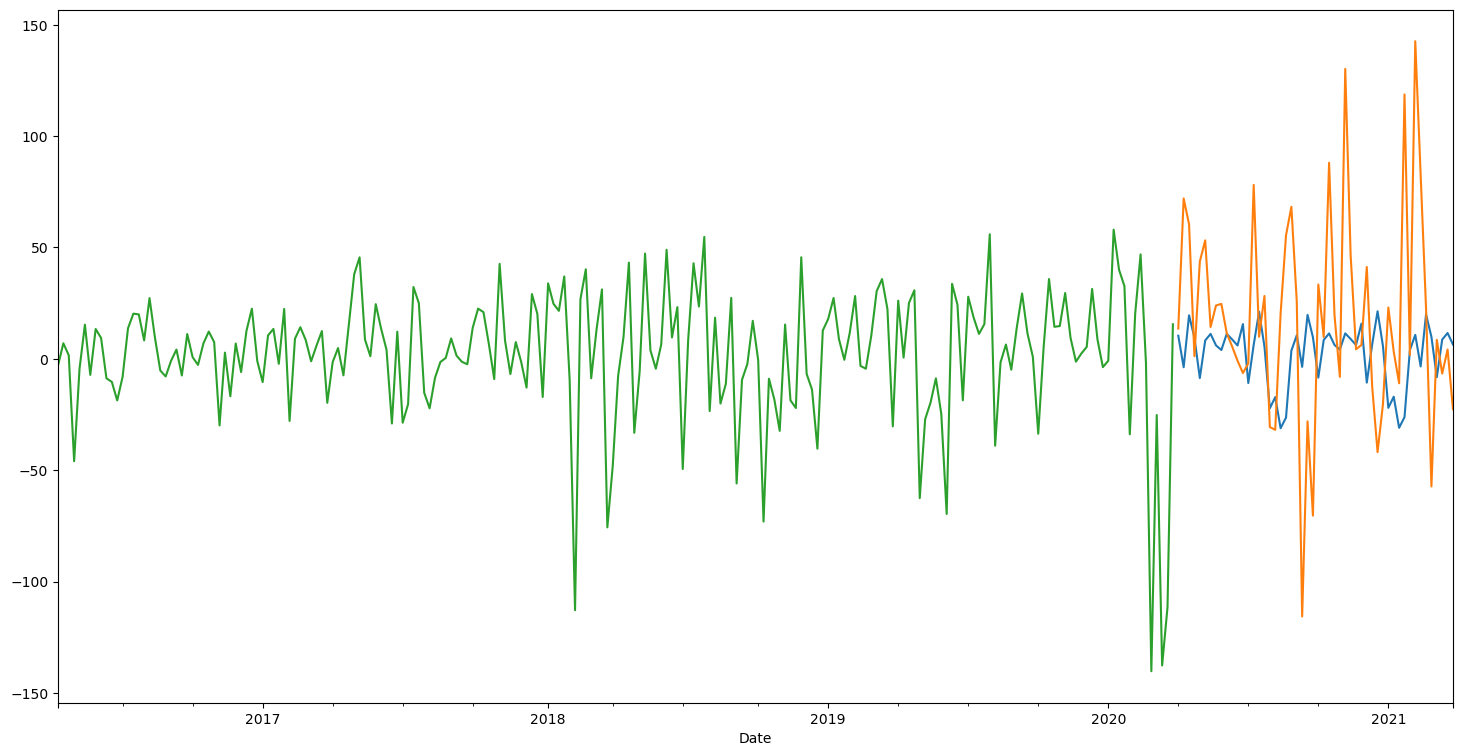

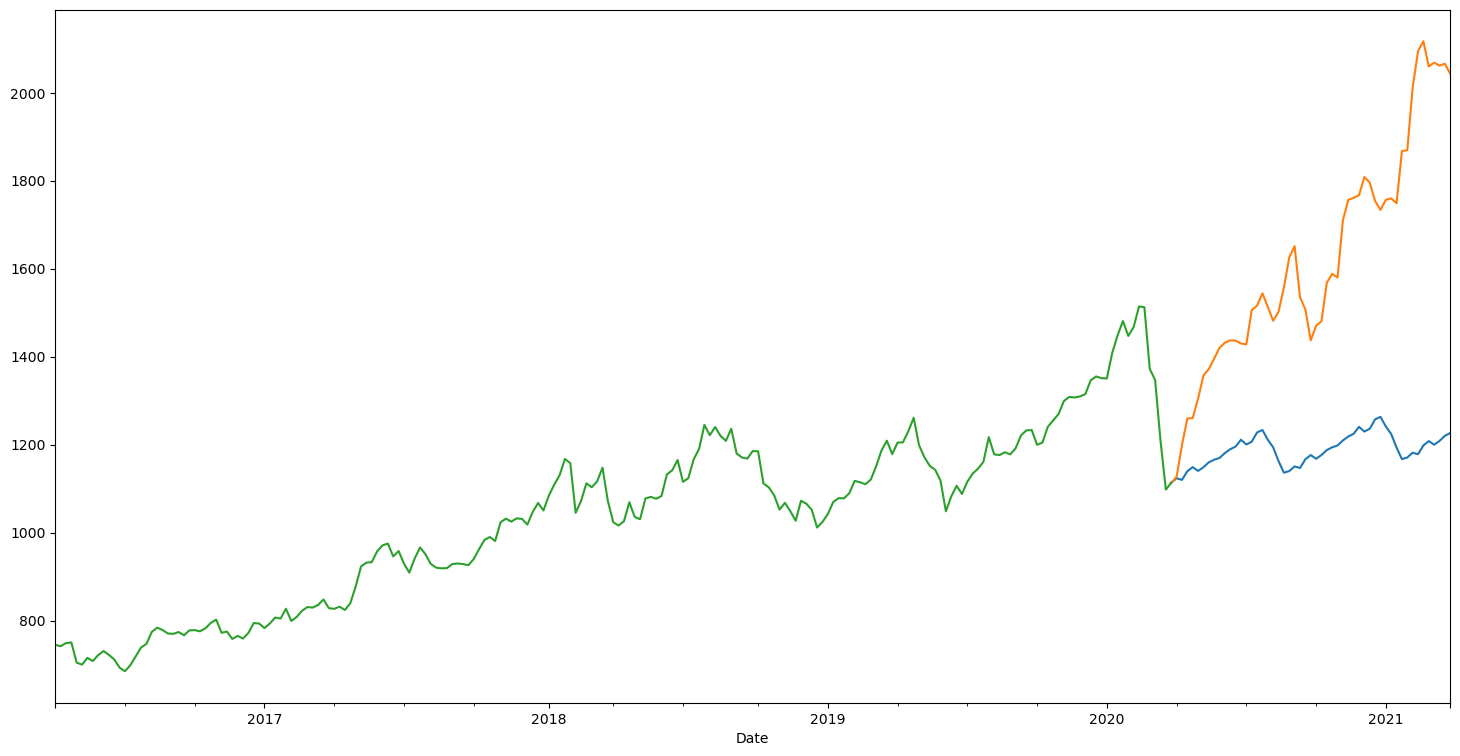

In [49]:
optimizer = minimize(timeseriesCVscore, x0=[0, 0, 0], method="L-BFGS-B", bounds=((0, 1), (0, 1), (0, 1)))
alpha, beta, gamma = optimizer.x

pred = HolterWinter(data=_train, L=L, alpha=alpha, beta=beta, gamma=gamma, m=len(_test))
_pred = _test.copy()
for i in range(len(_pred)):
    _pred[i] = pred[i]

_pred.plot()
_test.plot()
_train.plot()
plt.show()


real_pred = undiff(close[len(_train):len(_train)+1], _pred)
real_test = undiff(close[len(_train):len(_train)+1], _test)
real_train = undiff(close[0:1], _train)

real_pred.plot()
real_test.plot()
real_train.plot()
plt.show()


HW_pred = _pred
HW_real_pred = real_pred

In [45]:
model = auto_arima(
    _train,
    start_p=0,
    start_q=0,
    test='adf',
    max_d=4,
    max_q=4,
    m=32,
    start_P=1,
    start_Q=1,
    D=1,
    seasonal=True,
    error_action='ignore',
    supress_warnings=True,
    trace=True,
)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[32] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(0,0,0)(0,1,0)[32] intercept   : AIC=1808.351, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[32] intercept   : AIC=1764.462, Time=1.87 sec
 ARIMA(0,0,1)(0,1,1)[32] intercept   : AIC=inf, Time=3.25 sec
 ARIMA(0,0,0)(0,1,0)[32]             : AIC=1806.381, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[32] intercept   : AIC=1808.243, Time=0.31 sec
 ARIMA(1,0,0)(2,1,0)[32] intercept   : AIC=1753.198, Time=4.60 sec
 ARIMA(1,0,0)(2,1,1)[32] intercept   : AIC=inf, Time=8.76 sec
 ARIMA(1,0,0)(1,1,1)[32] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(0,0,0)(2,1,0)[32] intercept   : AIC=1757.507, Time=3.26 sec
 ARIMA(2,0,0)(2,1,0)[32] intercept   : AIC=1752.885, Time=6.61 sec
 ARIMA(2,0,0)(1,1,0)[32] intercept   : AIC=1763.003, Time=2.66 sec
 ARIMA(2,0,0)(2,1,1)[32] intercept   : AIC=inf, Time=7.81 sec
 ARIMA(2,0,0)(1,1,1)[32] intercept   : AIC=inf, Time=5.17 sec
 ARIMA(3,0,0)(2,1,0)[32] intercept   : AIC=1751.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  208
Model:             SARIMAX(4, 0, 1)x(2, 1, [], 32)   Log Likelihood                -865.319
Date:                             Tue, 25 Oct 2022   AIC                           1746.637
Time:                                     16:21:55   BIC                           1772.001
Sample:                                          0   HQIC                          1756.925
                                             - 208                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1453      0.079     14.468      0.000       0.990       1.300
ar.L2         -0.3560      0.099     -3.580      0.000      -0.551      -0.161
ar.L3          0.2831      0.139      2.043      0.041       0.012       0.555
ar.L4         -0.2128      0.084     -2.535      0.011      -0.377      -0.048
ma.L1         -0.9520      0.047    -20.273      0.000      -1.044      -0.860
ar.S.L32      -0.7484      0.082     -9.161      0.000      -0.909      -0.588
ar.S.L64      -0.3240      0.080     -4.071      0.000      -0.480      -0.168
sigma2       971.8995     88.718     10.955      0.000     798.016    1145.783
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.50
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.10   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

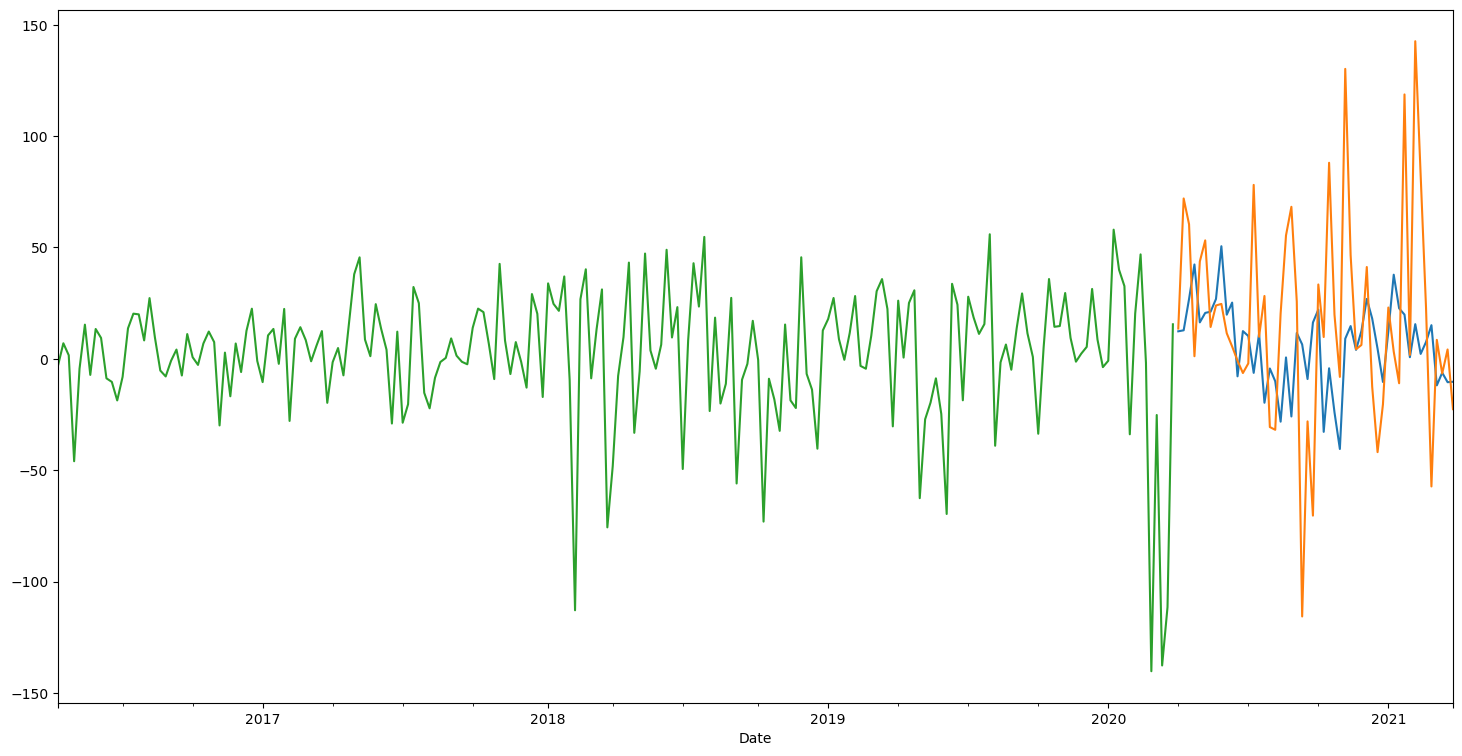

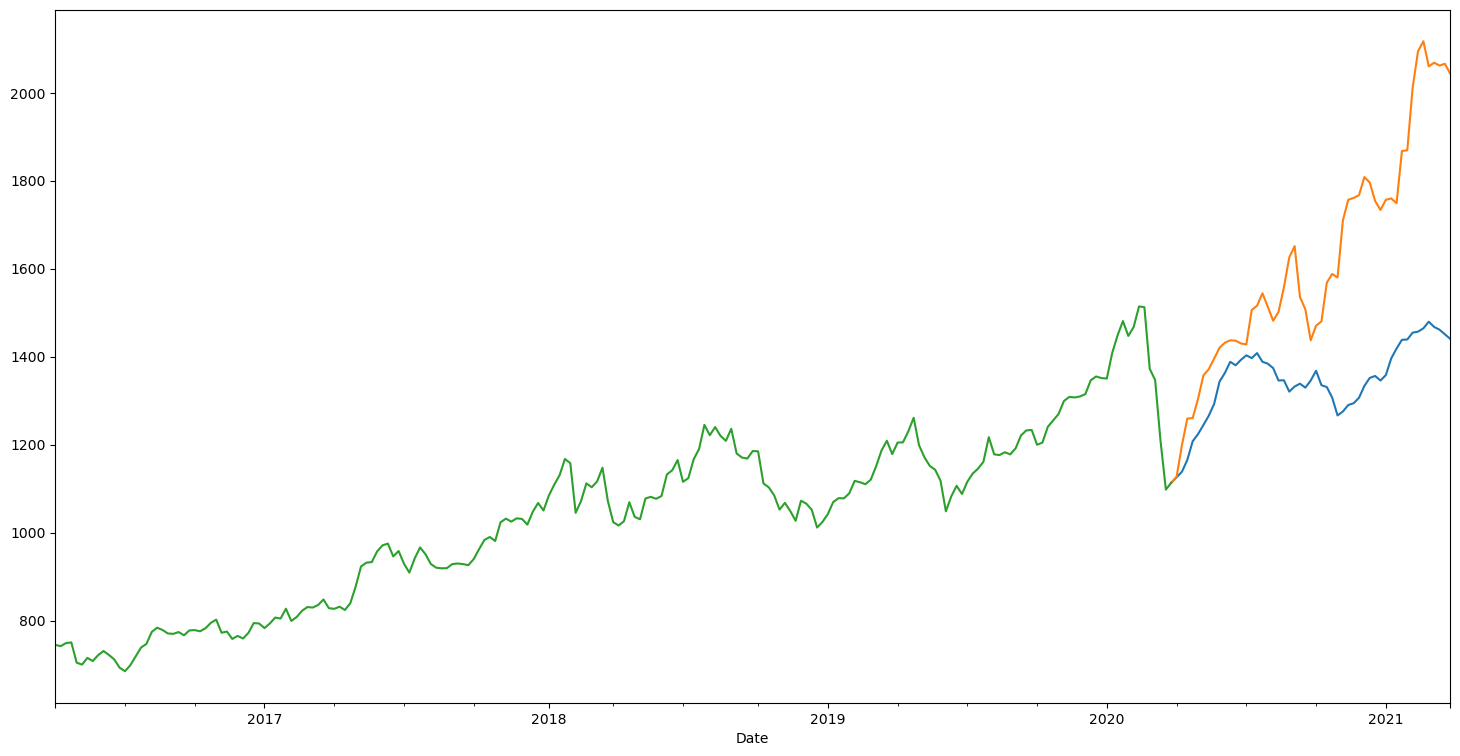

In [46]:
_pred = model.predict(n_periods=len(_test))
sarima_pred = _test.copy()
for i in range(len(sarima_pred)):
    sarima_pred[i] = _pred[i]

sarima_pred.plot()
_test.plot()
_train.plot()
plt.show()

sarima_pred = undiff(close[len(_train):len(_train)+1], sarima_pred)

sarima_pred.plot()
real_test.plot()
real_train.plot()
plt.show()

In [48]:
print("Holt-Winters:", mean_absolute_percentage_error(real_test, HW_real_pred))
print("SARIMA:", mean_absolute_percentage_error(real_test, sarima_pred))

Holt-Winters: 0.2478413168059648
SARIMA: 0.15366897108430683
